Dendrology is the study of trees. A critical aspect of this study is identification: the ability to look at a tree (or parts of one) and identify the family or species of the tree. Leaves are often the most easily recognizable features of trees. The goal here is to identify a tree species from a picture of its leaf.

That was the goal of Leafsnap (http://leafsnap.com/dataset/), a project to build an app with this feature. This notebook will use the dataset provided by Leafsnap's developers, consisting of roughly 23,000 high-quality leaf images taken in the same composition.

---

We'll start with data cleaning. 

Intraspecific variation -- the variation between individuals in a species -- is very high in leaves. Some may have shape differences, but shape is generally reliable. Color or venation patterns are too unreliable, with signficicant variation between individual leaves due to photographic quality, possible illnesses, or even time of year. It'd be useful if the dataset could just consist of the shapes of leaves, with these unreliable features removed. The developers of Leafsnap came to this conclusion, and designed an image segmentation algorithm. They've included a dataset of segmented leaf images. 

There's an issue though: roughly half of that dataset is bad data, errors of their algorithm. Manually removing these errors would be tedious, so I've built and applied a classifier to remove them automatically. The details of the process can be found here: https://github.com/MSDR/Projects-in-ML-and-AI/blob/main/HW5/Homework_5_Data_Cleaning.ipynb, with the resulting dataset saved as dataset/segmented-justleaves.

NOTE: The data cleaning notebook has an error itself. The list of classes was created by getting all file/directory names in datasets/segmented, which included the labels files themselves: labels.csv and labels.txt. Because of this, all species with names coming phoenetically after 'labels.txt' were put into the wrong folder. This error has been fixed and applied to the dataset used here. 

---

Though the segmented data's errors have now been cleaned out, there remains an issue: class imbalance and poor representation of some classes. 

Segmentation errors affected some classes more severely than others. For example, many pine species' segmentations were 100% error. 
To help resolve this issue, any classes with less than 20 examples have been removed, a total of 53/185. The original dataset is still available as dataset/segmented-justleaves, while the balanced dataset is available as dataset/segmented-justleaves-balanced.

---

Let's load this data and look at a sample:

Found 10467 files belonging to 132 classes.
Dataset split into 164 batches of 64 examples each.


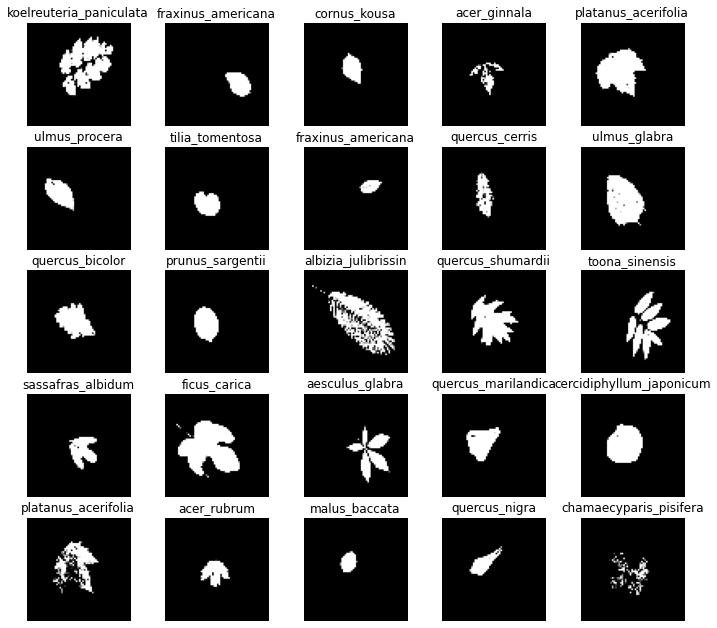

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#some hyperparameters:
imageSize = (64, 64)
imageSizeFlat = imageSize[0]*imageSize[1]
batchSize = 64

#load full leaf dataset
leafDir = "dataset/segmented-justleaves-balanced"
leavesData = tf.keras.preprocessing.image_dataset_from_directory(leafDir, labels='inferred', color_mode='grayscale', image_size=imageSize, batch_size=batchSize, shuffle=True)

#yield some information from dataset
leavesSize = leavesData.cardinality().numpy()
print("Dataset split into", leavesSize, "batches of", batchSize, "examples each.")

#create a list of species labels
#the index of each label here corresponds to the integer-value label keras inferred
labelText = open("dataset/labels-balanced.txt", "r")
speciesLabels = labelText.read()
speciesLabels = speciesLabels.split('\n')

#plot a sample of the dataset
plt.figure(figsize=(12, 11))
displayCount = 0
for images, labels in leavesData.take(2):
    for i in range(batchSize):
        ax = plt.subplot(5, 5, displayCount + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap='gray', vmin=0, vmax=255)
        plt.title(speciesLabels[int(labels[i])])
        plt.axis("off")    

        displayCount += 1
        if(displayCount==25):
            break
    if(displayCount==25):
        break

Now we split the dataset into train/dev/test sets. The data will also be prefetched to speed up training.

In [42]:
leavesSplit = [0.8, 0.1, 0.1] #train/dev/test split ratios

#split the data
leavesTrainSize = int(leavesSplit[0] * leavesSize)
leavesDevSize = int(leavesSplit[1] * leavesSize)
leavesTrainSet = leavesData.take(leavesTrainSize)    
leavesDevSet = leavesData.skip(leavesTrainSize).take(leavesDevSize)
leavesTestSet = leavesData.skip(leavesTrainSize).skip(leavesDevSize)

print("At", batchSize, "examples per batch:")
print("> Train set example count:", leavesTrainSet.cardinality().numpy()*batchSize)
print("> Dev set example count:  ", leavesDevSet.cardinality().numpy()*batchSize)
print("> Test set example count: ", leavesTestSet.cardinality().numpy()*batchSize)

leavesTrainSet = leavesTrainSet.prefetch(tf.data.experimental.AUTOTUNE)
leavesDevSet = leavesDevSet.prefetch(tf.data.experimental.AUTOTUNE)
leavesTestSet = leavesTestSet.prefetch(tf.data.experimental.AUTOTUNE)

At 64 examples per batch:
> Train set example count: 8384
> Dev set example count:   1024
> Test set example count:  1088


Next is to build the model. The architecture here is loosely inspired by Le-Net5, with two convolutional layers -- the first with far fewer filters than the second -- and max pooling between them, followed by two densely connected layers of decreasing size, then outputted into a softmax. Max pooling was selected as the pooling method because it selects well for bright pixels on a dark background. This architecture is simple, but so is the input data. Due to the segmentation, the only feature we're aiming to identify here is shape. A more complex structure may overfit more easily.

The hyperparameters of the pattern were chosen via manual tuning.

In [43]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Normalization

CNN = keras.Sequential([
    Normalization(),
    Conv2D(6, 3, input_shape=(imageSize[0], imageSize[1], 1)),
    MaxPooling2D(pool_size=2),
    Conv2D(16, 5),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(512, activation="tanh"),
    Dense(256, activation="tanh"),
    Dense(len(speciesLabels), activation="softmax")
])

#compile the model
CNN.compile(
  'adam',
  loss='sparse_categorical_crossentropy', #this loss function is easily compatible with the dataset intake function used (tf.keras.preprocessing.image_dataset_from_directory())
  metrics=['accuracy'],
)

These functions are useful for training, and will be used throughout the notebook:

In [44]:
#trains the model, returning a list of validation accuracy measures at the end of each epoch 
def trainModel(model, epochs, trainSet, devSet, earlyStopping=1, verbose=0):
  accLog = []
  valAccLog = []

  #train the model
  for e in range(epochs):
    model.fit(trainSet, epochs=1, validation_data=devSet, verbose=verbose)

    #record validation accuracy
    accLog += [ex for ex in model.history.history['accuracy']]
    valAccLog += [ex for ex in model.history.history['val_accuracy']]

    #implementation of early stopping
    if(e != epochs-1 and accLog[len(accLog)-1] >= earlyStopping): 
      print("==> Accuracy exceeded (or met) %d%%, early stopping initiated at epoch %d." % (earlyStopping*100, e+1))
      break 

  return (accLog, valAccLog)

def plotModelResults(logs, modelName, epochs):
  #graph accuracies
  plt.xlabel("Epochs")
  plt.xticks(range(0,epochs, int(epochs/10)))
  plt.ylabel("Accuracy")
  plt.title(modelName + " Accuracy throughout Training")
  plt.plot(logs[0], "c", label="Accuracy") 
  plt.plot(logs[1], "b", label="Val. Accuracy")
  plt.legend()
  plt.show()

Now we train the model:

In [45]:
cnnEpochs = 50 #while train accuracy doesn't converge until later, validation accuracy converges around epoch 40

#run 10 models
cnnTrainingLogs = trainModel(CNN, cnnEpochs, leavesTrainSet, leavesDevSet, earlyStopping=0.90, verbose=0)

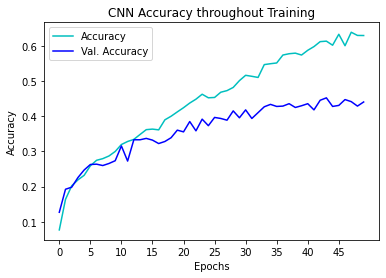

In [46]:
plotModelResults(cnnTrainingLogs, "CNN", cnnEpochs)

Not bad! Let's evaluate the test set:

In [47]:
CNN.evaluate(leavesTestSet)

17/17 [==============================] - 2s 11ms/step - loss: 2.6689 - accuracy: 0.3805


[2.668870210647583, 0.3805476725101471]

Especially between 132 possible classes, and considering the intraspecific variation within, a 38% validation accuracy is acceptable. It seems that the model overfits some, as the gap between training set accuracy and validation accuracy grows large.

I hypothesize that the model would perform significantly better in identifying the family of the tree -- maple (acer), oak (quercus), etc. -- due to intraspecific variation. Human dendrologers, especially beginners, demonstrate this as well. Individual species can sometimes be very difficult to distinguish, but families of trees are generally distinct, even when factoring in intraspecific variation.

---

Leafsnap was a mobile application, released on iOS in 2012. MobileNet is a CNN architecture specifically designed for low-power, often mobile devices. If we were to build a version of Leafsnap, MobileNet would be a consideration for the classification architecture. Let's see how it fares. 

First, we build and compile the model:

In [48]:
mobileNet = keras.Sequential([
    Normalization(),
    tf.keras.applications.MobileNet(input_shape=(imageSize[0], imageSize[1], 1), classes=len(speciesLabels), weights=None)
])

mobileNet.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy', #this loss function is easily compatible with the dataset intake function used (tf.keras.preprocessing.image_dataset_from_directory())
    metrics=['accuracy']
)

Now, we train it:

In [49]:
mobileNetEpochs = 35 #model converges around epoch 30
mobileNetLogs = trainModel(mobileNet, mobileNetEpochs, leavesTrainSet, leavesDevSet, earlyStopping=0.90, verbose=0)

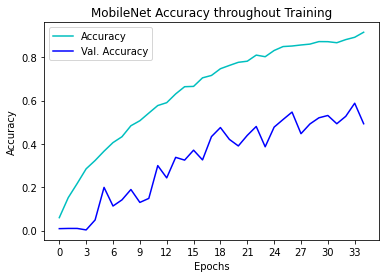

In [51]:
plotModelResults(mobileNetLogs, "MobileNet", mobileNetEpochs)

In [50]:
mobileNet.evaluate(leavesTestSet)

17/17 [==============================] - 3s 62ms/step - loss: 4.3061 - accuracy: 0.3966


[4.30613374710083, 0.3966005742549896]

The results after training are about the same as the custom architecture. Either ~40% accuracy is the 'limit' to how good a model can get based on the data, or both models are missing key features a deeper/more complex model would pick up.

Notably, MobileNet converged in less epochs. Runtimes are longer for MobileNet at 62ms/step vs. 11ms/step for the custom architecture, which makes sense given it's more complex. If prioritizing speed, which a mobile app may do, the custom architecture could be a better option. However, given the power of today's smartphones, the difference in time to evaluate a single image is so small that it wouldn't matter.

---

Last is data augmentation. We'll apply some simple augmentations to the data before passing it through the custom architecture for training.

Let's build the data augmentation model. For each input image, it'll flip either vertically or horizontally, then rotate the image slightly.

In [52]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

Let's see how this can affect a sample image:

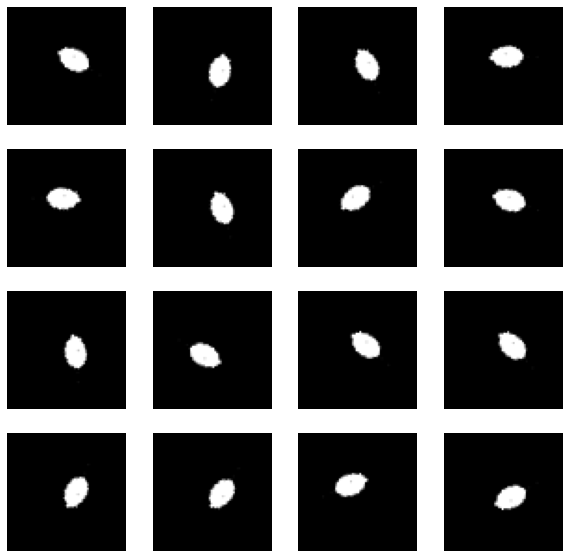

In [53]:
leafExample = leavesData.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(16):
    augLeaf = data_augmentation(leafExample[0])
    plt.subplot(4, 4, i+1)
    plt.imshow(augLeaf[0], cmap='gray', vmin=0, vmax=255)
    plt.axis("off")

Now we build and compile the full model:

In [54]:
augCNN = keras.Sequential([
    data_augmentation,
    Normalization(),
    Conv2D(6, 5, input_shape=(imageSize[0], imageSize[1], 1)),
    MaxPooling2D(pool_size=2),
    Conv2D(16, 5),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(512, activation="tanh"),
    Dense(256, activation="tanh"),
    Dense(len(speciesLabels), activation="softmax")
])

#compile the model
augCNN.compile(
  'adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

And run the model:

In [55]:
augCNNEpochs = 75
augCNNLogs = trainModel(augCNN, augCNNEpochs, leavesTrainSet, leavesDevSet, earlyStopping=0.90, verbose=0)

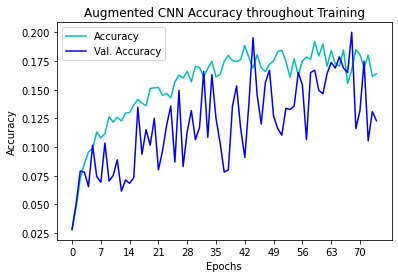

In [56]:
plotModelResults(augCNNLogs, "Augmented CNN", augCNNEpochs)

Yikes.

In [57]:
augCNN.evaluate(leavesTestSet)

17/17 [==============================] - 2s 11ms/step - loss: 3.6771 - accuracy: 0.1190


[3.6770803928375244, 0.11898016929626465]

This model doesn't perform well. It's possible that the original dataset had bias that affected the outcome, and now that this bias has been mitigated, the model doesn't perform well. The models prior could have fitted to that bias, additionally/rather than the shape of the leaves. It's also possible that the augmentations reduced the quality and differentiability of the inputs. 

There are many possible reasons why the performance suffers so much with augmentations, determining which would require further experimentation.